In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy import signal

from tqdm import tqdm

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ews_analysis import hopf_helper as hh
from ews_analysis.saddlenode_ews import dSdt as sd_model
from ews_analysis.pitchfork_helper import *
from ews_helper import get_ews, itoEulerMaruyama, get_acorr_decay_time

from scipy.integrate import odeint, solve_ivp


## Saddle-Node

In [2]:
def plot_bif_sim(fig, axs, time, results, derivatives):

    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])
    
    axs[0].plot(time, results[:,0])
    axs[0].set_xlabel('Time')
    # make ax grey
    axs[0].set_facecolor(plt.cm.gray(.85))

    # plot t_star, where r(t) = 0 = r0 + epsilon*t 
    t_star = time[np.where(results[:,1] >= 0)[0][0]]
    axs[0].axvline(t_star, c='r', ls='--') #label=f't*={t_star:.2f}'

    # ax.set_ylim(-20, 70)
    # axs[0].legend()
    axs[0].grid()
    return fig, axs, t_star

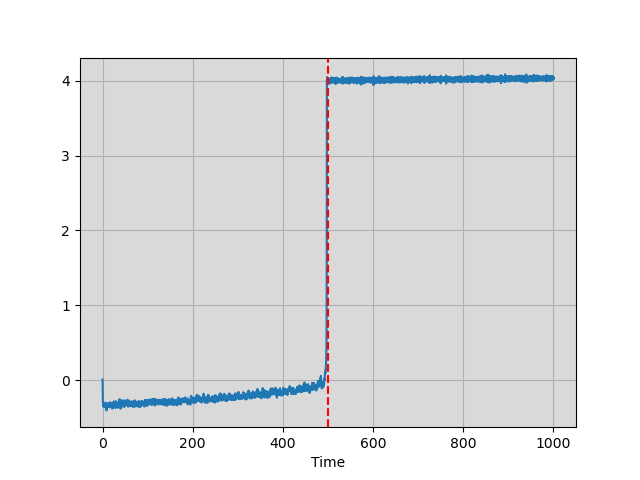

In [3]:
# f = np.load('tmp_figs/sd_bif_sim.npz')
f = np.load('tmp_figs/sd_with_yuval_bif.npz')

time=f['time'] 
results=f['results']
derivatives=f['derivatives']

fig, axs = plt.subplots(1)
fig, axs, t_star = plot_bif_sim(fig, axs, time, results, derivatives)

In [5]:
m =np.where(time==t_star)[0][0]

d_results_pre = signal.detrend(results[:m, 0])
d_results_post = signal.detrend(results[m:, 0])
d_results = np.concatenate([d_results_pre, d_results_post])

# print(d_results.shape, results[:,0].shape)

# fig, axs = plt.subplots(1)
# axs.plot(time, results[:,0], label='data as is')
# axs.plot(time, d_results, label='detrended around t*')

# plt.legend()
# plt.grid()

  0%|          | 0/65 [00:00<?, ?it/s]

100%|██████████| 65/65 [00:00<00:00, 3218.01it/s]


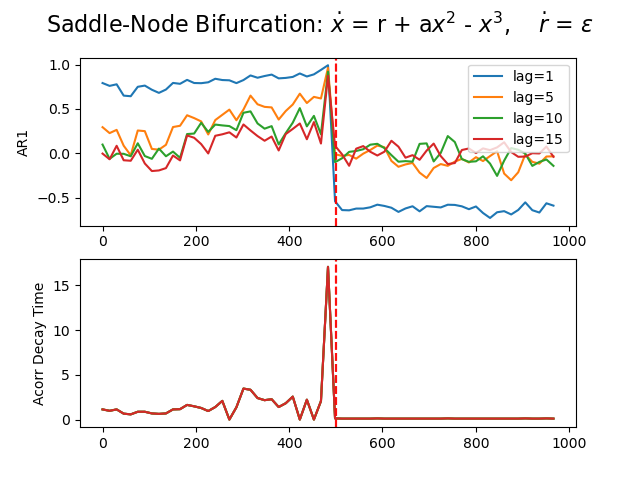

In [8]:
"""
time = np.arange(0, 9, 0.001)
r0 = -3
x0 = 0.1
a = 80
epsilon = 1.5
sigma = 0.33
"""

ews_fig, ews_axs = plt.subplots(2,1)

# win_size = ews_win_size = 101
for win_size in [301]:
    # win_size = ews_win_size = 101
    offset = ews_offset = win_size//2 + 1
    for lag in [7]:
        offset = ews_offset #= int(win_size*d) + (1 - (int(win_size*d) % 2))
        # print(time.shape)

        block_idxs_sd, ar1s_sd, decays_sd, vars_sd = get_ews(
            time, results[:,0], win_size=win_size, offset=offset, lag=lag
        )
        # block_idxs_sd, ar1s_sd, decays_sd, vars_sd = get_ews(
        #     time, d_results, win_size=win_size, offset=offset
        # )

        # ews_fig, ews_axs = plt.subplots(2,1)

        # Plot AR1s
        ews_axs[0].plot(time[block_idxs_sd[:len(ar1s_sd)]], ar1s_sd, label=f'lag={lag}')
        ews_axs[0].axvline(
            t_star, color='r', linestyle='--', 
            alpha=0.5
        )
        ews_axs[0].set_ylabel('AR1')

        # Plot Decays
        ews_axs[1].plot(time[block_idxs_sd[:len(decays_sd)]], decays_sd)
        ews_axs[1].axvline(
            t_star, color='r', linestyle='--', 
            alpha=0.5, label='x=0'
        )

ews_axs[1].set_ylabel('Acorr Decay Time')
ttl = r'Saddle-Node Bifurcation: $\dot{x}$ = r + a$x^2$ - $x^3$,    $\dot{r}$ = $\epsilon$'
ews_fig.suptitle(ttl, fontsize=16)
ews_axs[0].legend()

In [ ]:
# get_acorr_decay_time

def get_acorr_decay_time(arr, dt):
    try:
        frame_rate = 1
        tmp_a = z_score_normalizer(arr)
        if (tmp_a==0).all():
            tmp_a = np.ones_like(tmp_a)
        if tmp_a.size == 0:
            raise Exception('tmp_a.size == 0')
        acorr = np.correlate(tmp_a, tmp_a, mode='full') / (tmp_a.size - 1)

        idx = solve_equality(
            acorr[acorr.size // 2:], 1 / np.e
        )
        yy = acorr[acorr.size // 2:]
        xx = np.arange(yy.size) / frame_rate
        piecewise_linear_acorr = interp1d(xx, yy, kind='linear')
        # # todo: find real delta and frame rate
        delta = dt
        grained_xx = np.arange(0, idx, delta) / frame_rate
        approximation = piecewise_linear_acorr(grained_xx)
        decay_time = solve_equality(
            approximation, 1 / np.e
        ) #* delta / frame_rate
    except Exception as e:
        print(f'error in get_acorr_decay_time\n{e}')
        raise e



## Pitchfork

In [ ]:
# f = np.load('tmp_figs/pf_bif_sim.npz')
# time=f['time'] 
# results=f['results']
# derivatives=f['derivatives']

# fig, axs = plt.subplots(1)
# fig, axs, t_star = plot_bif_sim(fig, axs, time, results, derivatives)

In [ ]:
# win_size = ews_win_size = 301
# offset = ews_offset = 101

# print(time.shape)

# block_idxs, ar1s, decays, vars = get_ews(
#     time, results[:,0], win_size=win_size, offset=offset
# )

# ews_fig, ews_axs = plt.subplots(2,1)

# # Plot AR1s
# ews_axs[0].plot(time[block_idxs[:len(ar1s)]], ar1s)
# ews_axs[0].axvline(
#     t_star, color='r', linestyle='--', 
#     alpha=0.5, label='x=0'
# )

# # Plot Decays
# ews_axs[1].plot(time[block_idxs[:len(decays)]], decays)
# ews_axs[1].axvline(
#     t_star, color='r', linestyle='--', 
#     alpha=0.5, label='x=0'
# )

In [ ]:
"""
1. detrending the signal
per trajectory - when does it jump - i.e. signal chnages > 20% in a short time (say 40 ms)
linearly approximate the signal pre-jump and subtract from signal to remove upwards trend

2. ar1s???

3. divergence of sim away from x_dot roots plot
"""

In [ ]:
# a = np.random.normal(size=(1000))
# tmp_a = a - np.mean(a)
# ar1 = np.correlate(tmp_a, tmp_a, mode='full') / (np.cov(a)* (l-1))

# plt.plot(ar1)